## System Description
1. We have a set of COFs from a database. Each COF is characterized by a feature vector $$x_{COF} \in \mathcal{X} \subset R^d$$ were d=14.


2. We have **two different types** of simulations to calculate **the same material property $S_{Xe/Kr}$**. Therefore, we have a Single-Task/Objective 
$$argmax_{x_{COF} \in \mathcal{X}}[S_{Xe/Kr}(x_{COF})]$$

3. Multi-Fidelity problem. 
    1. low-fidelity  => Henry coefficient calculation - MC integration: $S_{Xe/Kr} = \frac{H_{Xe}}{H_{Kr}}$
    2. high-fidelity => GCMC mixture simulation - 80:20 (Kr:Xe) at 298 K and 1.0 bar: $S_{Xe/Kr} = \frac{n_{Xe} / n_{Kr}}{y_{Xe}/y_{Kr}}$


3. We will initialize the system with a few COFs at **both** fidelities in order to initialize the Covariance Matrix.
    1. The fist COF will be the one closest to the center of the normalized feature space
    2. The rest will be chosen to maximize diversity of the training set


4. Each surrogate model will **only train on data acquired at its level of fidelity** (Heterotopic data). $$X_{lf} \neq X_{hf} \subset X$$
    1. We  use the augmented-EI (aEI) acquisition function from [here](https://link.springer.com/content/pdf/10.1007/s00158-005-0587-0.pdf)
    2. Botorch GP surrogate model: [SingleTaskMultiFidelityGP](https://botorch.org/api/models.html#module-botorch.models.gp_regression_fidelity) or [FixedNoiseMultiFidelityGP](https://botorch.org/api/models.html#botorch.models.gp_regression_fidelity.FixedNoiseMultiFidelityGP)
    3. Needed to use [this](https://botorch.org/api/optim.html#module-botorch.optim.fit) optimizer to correct matrix jitter
    4. Helpful [tutorial](https://botorch.org/tutorials/discrete_multi_fidelity_bo) for a similar BoTorch Model used

## TODO:

1. there is a lot of switching between notation for the fidelities, make this more clear
2. double check that the places where the fidelity index and the fidelity value are being used correctly 
3. consolidate/correct information in the header of this notebok.

In [1]:
import torch
import gpytorch

from botorch.models import SingleTaskMultiFidelityGP

from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
###
#  fix Cholecky jitter error:
#  the line search in the L-BFGS algorithm, used by default, can take some very large steps, 
#  which in turn causes numerical issues in the solves in the underlying gpytorch model.
#
#  recommended solution: use an optimizer from torch.optim to fit the model
#  see [posted issue here](https://github.com/pytorch/botorch/issues/179#issuecomment-504798767)
###
from botorch.optim.fit import fit_gpytorch_torch 

from scipy.stats import norm
import numpy as np
import pickle
import h5py # for .jld2 files
import os
import time

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
###
#  figure settings 
###
import seaborn as sns
sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['figure.dpi'] = 1200 # 600-1200 for paper quality

<Figure size 640x480 with 0 Axes>

## Load Data

In [3]:
###
#  load data: targets and features
###
normalization = "normalized" 
file = h5py.File("targets_and_normalized_features.jld2", "r")


# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:]))

# simulation data
y = [torch.from_numpy(np.transpose(file["henry_y"][:])), 
     torch.from_numpy(np.transpose(file["gcmc_y"][:]))]  

# associated simulation costs
cost = [np.transpose(file["henry_total_elapsed_time"][:]), # [min]
        np.transpose(file["gcmc_elapsed_time"][:])]        # [min]

# total number of COFs in data set
nb_COFs = X.shape[0] 


###
#  load data: initializing COFs
###
init_cof_ids_file = pickle.load(open(
                    'search_results/normalized/initializing_cof_ids_normalized.pkl', 'rb'))

init_cof_ids = init_cof_ids_file['init_cof_ids']

# total number of BO searches to run = number of initializing sets
nb_runs = len(init_cof_ids)


###
#  print information about data
###
# cost
print("total high-fidelity cost:", sum(cost[1]).item(), "[min]")
print("total low-fidelity cost: ", sum(cost[0]).item(), "[min]")
print("average high-fidelity cost:", np.mean(cost[1]), "[min]")
print("average low-fidelity cost: ", np.mean(cost[0]), "[min]")
print("average cost ratio:\t   ", np.mean(cost[1] / cost[0]))
# data shape
print("\nraw data - \n\tX:", X.shape)
for f in range(2):
    print("\tfidelity:", f)
    print("\t\ty:", y[f].shape)
    print("\t\tcost: ", cost[f].shape)
# normalization 
print("\nEnsure features are normalized - ")
print("max:\n", torch.max(X, 0).values)
print("min:\n", torch.min(X, 0).values)
print("width:\n",torch.max(X, 0).values - torch.min(X, 0).values)
print("mean:\n", torch.mean(X, 0))
print("std:\n", torch.std(X, 0))

total high-fidelity cost: 139887.66223703226 [min]
total low-fidelity cost:  10076.305239888028 [min]
average high-fidelity cost: 230.0783918372241 [min]
average low-fidelity cost:  16.57287046034216 [min]
average cost ratio:	    13.444745568580501

raw data - 
	X: torch.Size([608, 14])
	fidelity: 0
		y: torch.Size([608])
		cost:  (608,)
	fidelity: 1
		y: torch.Size([608])
		cost:  (608,)

Ensure features are normalized - 
max:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
min:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
width:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
mean:
 tensor([0.2856, 0.5864, 0.5304, 0.3323, 0.0421, 0.1617, 0.6405, 0.6793, 0.0062,
        0.1758, 0.0308, 0.0131, 0.0132, 0.0238], dtype=torch.float64)
std:
 tensor([0.1586, 0.1787, 0.1896, 0.1512, 0.1150, 0.1916, 0.1631, 0.1354, 0.0631,
        0.1126, 0.1026, 0.0935,

## Helper Functions

#### Post-Search Analysis

In [4]:
def calc_fidelity_fraction(acquired_set, fidelity):
    nb_iters = len(acquired_set)
    fid_frac = np.zeros(nb_iters)
    for i in range(1, nb_iters):
        fid_frac[i] = sum(acquired_set[:, 0][:i+1] == fidelity) / (i+1)
    return fid_frac

In [5]:
# very crude way to get fidelity id
# exploits lf < 0.5 and hf > 0.5
def get_f_ids(acquired_set):
    if acquired_set.dim() == 0:
        return acquired_set.round().to(dtype=int)
    else: 
        f_ids = [a[0].round().to(dtype=int) for a in acquired_set]
        return torch.tensor(f_ids)

In [6]:
def get_y_maxes_acquired(acquired_set):    
    nb_iters = len(acquired_set)
    y_maxes = np.zeros(nb_iters)
    # we want the maximum y value (only high-fidelity) up to a given iteration
    y_max = 0.0 # update this each iteration.
    for i, (f_val, cof_id) in enumerate(acquired_set):
        f_id = get_f_ids(torch.tensor(f_val))
        y_acq_this_iter = y[f_id][int(cof_id)]
        # i is iteration index
        if f_id == 1 and y_acq_this_iter > y_max:  
            y_max = y_acq_this_iter # over-write max
        y_maxes[i] = y_max 
    return y_maxes

In [7]:
def accumulated_cost(cost_acquired):
    nb_iters = len(acquired_set)
    accumulated_cost = np.zeros(nb_iters)
    accumulated_cost[0] = cost_acquired[0]
    for i in range(1, len(cost_acquired)):
        accumulated_cost[i] = accumulated_cost[i-1] + cost_acquired[i]
    return accumulated_cost

#### Construct Initial Inputs

In [8]:
def initialize_acquired_set(X, y, initializing_COFs, discrete_fidelities):
#     cof_ids = diverse_set(X, nb_COFs_initialization) # np.array(ids_train)
    return torch.tensor([[f_id, cof_id] for cof_id in initializing_COFs for f_id in discrete_fidelities])

In [9]:
# construct feature matrix of acquired points
def build_X_train(acquired_set):
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    f_ids = torch.tensor([a[0] for a in acquired_set])
    return torch.cat((X[cof_ids, :], f_ids.unsqueeze(dim=-1)), dim=1)

# construct output vector for acquired points
def build_y_train(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)

# construct vector to track accumulated cost of acquired points
def build_cost(acquired_set):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids)]).unsqueeze(-1)

# construct vector to track accumulated cost of acquired points
def build_cost_fidelity(acquired_set, fidelity):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return torch.tensor([cost[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == fidelity]).unsqueeze(-1)

#### test

In [10]:
def test_initializing_functions(X, y):
    ###
    #  construct training sets
    ###
    # list of (cof_id, fid_id)'s
    acquired_set = torch.tensor([[2/3, 10], [1/3, 3], [1/3, 4]])
    
    # Training Sets
    X_train = build_X_train(acquired_set)
    y_train = build_y_train(acquired_set)
    
    ###
    #  test that the constructor functions are working properly
    ###
    assert np.allclose(X[10, :], X_train[0, :14])
    assert np.isclose(X_train[0, 14], 2/3) # high-fidelity
    assert np.isclose(X_train[1, 14], 1/3) # low-fidelity
    assert y_train[0] == y[1][10] # y[fid_id][cof_id]
    assert y_train[2] == y[0][4]
    return

test_initializing_functions(X, y)

### Surrogate Model

In [11]:
def train_surrogate_model(X_train, y_train):
    model = SingleTaskMultiFidelityGP(
        X_train, 
        y_train, 
        linear_truncated=False, # RBF for features and Downsampling for Fidelities
        outcome_transform=Standardize(m=1), # m is the output dimension
        data_fidelity=X_train.shape[1] - 1
    )   
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll, optimizer=fit_gpytorch_torch)
    return model

### Acquisition Function

In [12]:
# calculate posterior mean and variance for a given fidelity
def mu_sigma(model, X, fidelity):
    nb_COFs_here = X.size()[0]
    f = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs_here, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    f_posterior = model.posterior(X_f)
    return f_posterior.mean.squeeze().detach().numpy(), np.sqrt(f_posterior.variance.squeeze().detach().numpy())

# get the current best y-value of desired_fidelity in the acquired set
def get_y_max(acquired_set, desired_fidelity):
    f_ids = get_f_ids(acquired_set)
    cof_ids = [a[1].to(dtype=int) for a in acquired_set]
    return np.max([y[f_id][cof_id] for f_id, cof_id in zip(f_ids, cof_ids) if f_id == desired_fidelity])

In [13]:
###
#  efficient multi-fidelity correlation function
#  corr(y at given fidelity, y at high-fidelity)
#  (see notes)
###
def mfbo_correlation_function(model, X, fidelity):
    # given fidelity
    f   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * fidelity
    X_f = torch.cat((X, f), dim=1) # last col is associated fidelity
    
    #  high-fidelity
    hf   = torch.tensor((), dtype=torch.float64).new_ones((nb_COFs, 1)) * discrete_fidelities[-1]
    X_hf = torch.cat((X, hf), dim=1) # last col is associated fidelity

    # combine into a single tensor
    X_all_fid = torch.cat((X_f, X_hf), dim=0)
    
    # get variance for each fidelity
    var_f = torch.flatten(model.posterior(X_f).variance)
    var_hf = torch.flatten(model.posterior(X_hf).variance) # variance
    
    # posterior covariance 
    cov = torch.diag(model(X_all_fid).covariance_matrix[:X_f.size()[0], X_f.size()[0]:])
    
    corr = cov / (torch.sqrt(var_f) * torch.sqrt(var_hf))
    return corr

In [14]:
###
#  cost ratio
###
def estimate_cost_ratio(fidelity, acquired_set):
    f_id = get_f_ids(torch.tensor(fidelity))
    avg_cost_f  = torch.mean(build_cost_fidelity(acquired_set, f_id))
    avg_cost_hf = torch.mean(build_cost_fidelity(acquired_set, 1))
    cr = avg_cost_hf / avg_cost_f
    return cr.item()

###
#  expected imrovement function, only uses hf
###
def EI_hf(model, X, acquired_set):
    hf_mu, hf_sigma = mu_sigma(model, X, 1)
    y_max = get_y_max(acquired_set, 1)
    
    z = (hf_mu - y_max) / hf_sigma
    explore_term = hf_sigma * norm.pdf(z) 
    exploit_term = (hf_mu - y_max) * norm.cdf(z) 
    ei = explore_term + exploit_term
    return np.maximum(ei, np.zeros(nb_COFs))

###
#  acquisition function
###
def acquisition_scores(model, X, fidelity, acquired_set):
    # expected improvement for high-fidelity
    ei = EI_hf(model, X, acquired_set) 
    
    # augmenting functions
    corr_f1_f0 = mfbo_correlation_function(model, X, fidelity)
    
    cr = estimate_cost_ratio(fidelity, acquired_set)

    scores = torch.from_numpy(ei) * corr_f1_f0 * cr
    return scores.detach().numpy()

def in_acquired_set(f_id, cof_id, acquired_set):
    for this_f_id, this_cof_id in acquired_set:
        if this_cof_id == cof_id and this_f_id == f_id:
            return True
    return False

### Bayesian Algorithm

In [15]:
def run_Bayesian_optimization(nb_iterations, initializing_COFs, verbose=False):
    assert nb_iterations > len(initializing_COFs)
    ###
    #  initialize system
    ###
    acquired_set = initialize_acquired_set(X, y, initializing_COFs, discrete_fidelities)
    
    ###
    #  itterate through remaining budget using BO
    ###
    for i in range(nb_COFs_initialization * len(discrete_fidelities), nb_iterations): 
        print("BO iteration: ", i)
        ###
        #  construct training data (perform experiments)
        ###
        X_train = build_X_train(acquired_set)
        y_train = build_y_train(acquired_set)

        if verbose:
            print("Initialization - \n")
            print("\tid acquired = ", [acq_[1].item() for acq_ in acquired_set])
            print("\tfidelity acquired = ", [acq_[0].item() for acq_ in acquired_set])
            print("\tcosts acquired = ", build_cost(acquired_set), " [min]")

            print("\n\tTraining data:\n")
            print("\t\t X train shape = ", X_train.shape)
            print("\t\t y train shape = ", y_train.shape)
            print("\t\t training feature vector = \n", X_train)
        
        ###
        #  train Model
        ###
        model = train_surrogate_model(X_train, y_train)
        
        ###
        #  acquire new (COF, fidelity) not yet acquired.
        ###
        # entry (fid_id, cof_id) is the acquisition value for fidelity f_id and cof cof_id
        the_acquisition_scores = np.array([acquisition_scores(model, X, f_id, acquired_set) for f_id in discrete_fidelities])
        
        # overwrite acquired COFs/fidelities with negative infinity to not choose these.
        for f_id, cof_id in acquired_set:
            the_acquisition_scores[get_f_ids(f_id), cof_id.to(dtype=int)] = - np.inf
        
        # select COF/fidelity with highest aquisition score.
        f_id, cof_id = np.unravel_index(np.argmax(the_acquisition_scores), np.shape(the_acquisition_scores))
        assert not in_acquired_set(f_id, cof_id, acquired_set)
        
        # update acquired_set
        acq = torch.tensor([[discrete_fidelities[f_id], cof_id]]) # dtype=int
        print(acq)
        acquired_set = torch.cat((acquired_set, acq))

        ###
        #  print useful info
        ###
        if verbose:
            print("\tacquired COF ", cof_id, " at fidelity, ", f_id)
            print("\t\ty = ", y[f_id][cof_id].item())
            print("\t\tcost = ", cost[f_id][cof_id])
        
    return acquired_set

# Run MFBO

In [16]:
###
#  construct initial inputs
###
# discrete_fidelities = [0, 1] # set of discrete fidelities to select from
discrete_fidelities = [1/3, 2/3] # set of discrete fidelities (in ascending order) to select from

nb_COFs_initialization = 3   # at each fidelity, number of COFs to initialize with
nb_iterations = 150          # BO budget, includes initializing COFs

In [17]:
ids_acquired = run_Bayesian_optimization(nb_iterations, init_cof_ids[0])

BO iteration:  6
Iter 10/100: 1.8533821698376691
Iter 20/100: 1.2318246162438156
Iter 30/100: 1.0359267444280056
Iter 40/100: 0.733527664599651
tensor([[3.3333e-01, 5.2100e+02]])
BO iteration:  7
Iter 10/100: 1.795051305724461
Iter 20/100: 1.2592560620756352
Iter 30/100: 1.0861461086602395
Iter 40/100: 0.8116732587238366
tensor([[3.3333e-01, 5.2300e+02]])
BO iteration:  8
Iter 10/100: 1.7526550551842104
Iter 20/100: 1.2738434262426834
Iter 30/100: 1.1090000908408055
Iter 40/100: 0.8588476973668293
tensor([[3.3333e-01, 5.2400e+02]])
BO iteration:  9
Iter 10/100: 1.735277483594476
Iter 20/100: 1.3056512096949453
Iter 30/100: 1.1560745234976295
Iter 40/100: 0.9286123665565797
tensor([[3.3333e-01, 5.8300e+02]])
BO iteration:  10
Iter 10/100: 1.717197117297942
Iter 20/100: 1.3233219073584257
Iter 30/100: 1.1806811508839576
Iter 40/100: 0.9629830720614642
tensor([[0.3333, 0.0000]])
BO iteration:  11
Iter 10/100: 1.6972867777156098
Iter 20/100: 1.3326490656675423
Iter 30/100: 1.19384255422308

In [18]:
# unpack search results
fids = [ids_acquired[i][0].item() for i in range(len(ids_acquired))]
cof_ids = [int(ids_acquired[i][1].item()) for i in range(len(ids_acquired))]

# which COF has the largest high-fidelity selectivity?
cof_id_with_max_hi_fid_selectivity = np.argmax(y[1]).item()

# iteration we found top COF
n_iter_top_cof_found = np.where([cof_ids[i] == cof_id_with_max_hi_fid_selectivity and fids[i] > 0.5 for i in range(len(cof_ids))])[0].item()
n_iter_top_cof_found

47

In [19]:
# plot the selectivities of COFs acc to low vs high fid

# which COFs are sampled at both fidelities?
hi_fid_cofs = [cof_ids[i] for i in range(n_iter_top_cof_found) if fids[i] > 0.5]
lo_fid_cofs = [cof_ids[i] for i in range(n_iter_top_cof_found) if fids[i] < 0.5]
ids_cofs_hi_and_lo_fid = np.intersect1d(hi_fid_cofs, lo_fid_cofs)
ids_cofs_hi_and_lo_fid

array([ 45, 112, 212, 237, 319, 521, 522, 523])

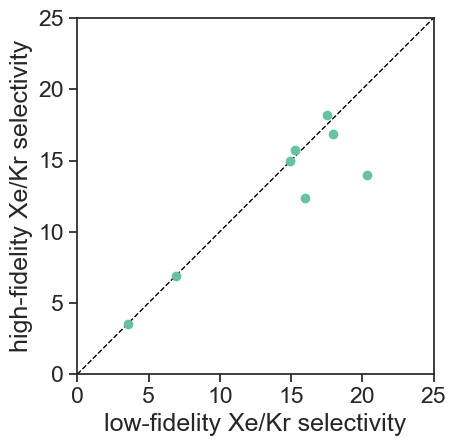

In [20]:
# build selectivity array for plotting
y_los = [y[0][c].item() for c in ids_cofs_hi_and_lo_fid]
y_his = [y[1][c].item() for c in ids_cofs_hi_and_lo_fid]

fig = plt.figure()
plt.plot([0, 25], [0, 25], linestyle="--", color="k", linewidth=1)
plt.scatter(y_los, y_his, zorder=10)
ax = plt.gca()
plt.xlim(0, 25)
plt.ylim(0, 25)
ax.set_aspect("equal", "box")
plt.xlabel("low-fidelity Xe/Kr selectivity")
plt.ylabel("high-fidelity Xe/Kr selectivity")
plt.tight_layout()
plt.savefig("lo_vs_hi_fid_selectivity.pdf", format='pdf')

In [21]:
# get COF ids not in acquired set.
test_cof_ids = [cof_id for cof_id in range(nb_COFs) if not (cof_id in hi_fid_cofs)]
len(test_cof_ids)

600

In [22]:
cof_id_with_max_hi_fid_selectivity in test_cof_ids

True

In [23]:
id_in_test_cofs_of_opt_cof = np.where([c == cof_id_with_max_hi_fid_selectivity for c in test_cof_ids])[0].item()
id_in_test_cofs_of_opt_cof

370

Iter 10/100: 1.519060126344956
Iter 20/100: 1.3759638335446003
Iter 30/100: 1.2626277254306222
Iter 40/100: 1.0676974104464092


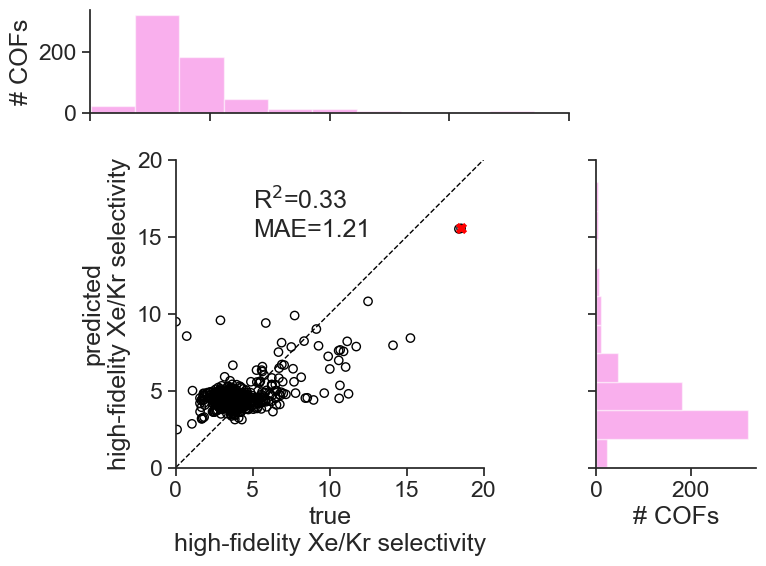

In [48]:
# train surrogate model for test data, on acquired set up till top COF was found.
X_train = build_X_train(ids_acquired[:n_iter_top_cof_found])
y_train = build_y_train(ids_acquired[:n_iter_top_cof_found])

model = train_surrogate_model(X_train, y_train)

# get model predictions on test COFs, for high-fidelity.
y_pred, sigma = mu_sigma(model, X[test_cof_ids, :], discrete_fidelities[-1])

# plot true vs predicted
y_true = [y[1][c].item() for c in test_cof_ids]

r2 = r2_score(y_true, y_pred)
abserr = mean_absolute_error(y_true, y_pred)


###
#  parity plot
###
gridspec_kw={'width_ratios': [6, 2], 'height_ratios': [2, 6]} # set ratios
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=gridspec_kw, figsize=(8, 6))
# fig = plt.figure()
ax[0, 1].axis("off")
ax[1, 0].plot([0, 20], [0, 20], linestyle="--", color="k", linewidth=1)
# ax = plt.gca()
ax[1, 0].set_xlim(0, 20)
ax[1, 0].set_ylim(0, 20)

ax[1, 0].set_aspect("equal", "box")

ax[1, 0].text(5, 15, "R$^2$=%.2f\nMAE=%.2f" % (r2, abserr))
ax[1, 0].scatter(y_true, y_pred, fc='none', ec="k")
ax[1, 0].set_xlabel("true\nhigh-fidelity Xe/Kr selectivity")
ax[1, 0].set_ylabel("predicted\nhigh-fidelity Xe/Kr selectivity")
# plot acquired COF
ax[1, 0].scatter(y_true[id_in_test_cofs_of_opt_cof], y_pred[id_in_test_cofs_of_opt_cof], marker="x", color="red")


###
#  histogram of selectivities
###
hist_color = sns.color_palette("husl", 8)[7]
ax[0, 0].hist(y[1].tolist(), color=hist_color, alpha=0.5) # 
ax[0, 0].sharex(ax[1, 0])
ax[0, 0].set_ylabel('# COFs')
plt.setp(ax[0, 0].get_xticklabels(), visible=False) # remove yticklabels

hist_color = sns.color_palette("husl", 8)[7]
ax[1, 1].hist(y[1].tolist(), color=hist_color, alpha=0.5, orientation="horizontal") # 
ax[1, 1].sharey(ax[1, 0])
ax[1, 1].set_xlabel('# COFs')
plt.setp(ax[1, 1].get_yticklabels(), visible=False) # remove yticklabels

sns.despine()
ax[0, 0].sharex(ax[1, 0])
plt.tight_layout()
# plt.savefig("surrogate_parity.pdf", format="pdf")
plt.savefig("surrogate_parity_with_hist.pdf", format="pdf")

plt.show()

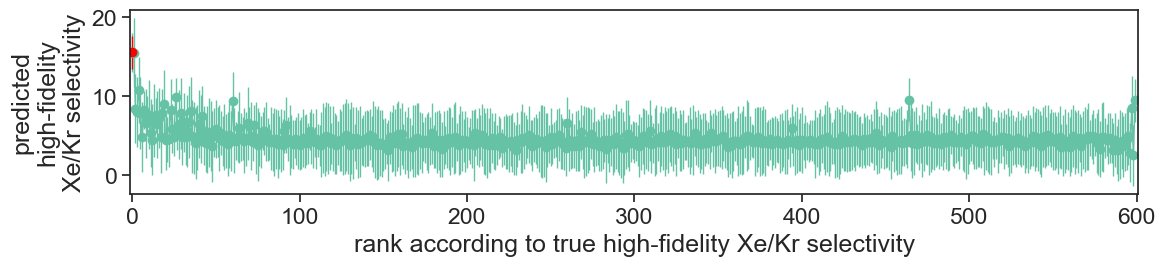

In [25]:
ids_sorted = np.argsort(y_true)[::-1]

plt.figure(figsize=(12, 3))
plt.errorbar(range(len(y_true)), y_pred[ids_sorted], yerr=sigma, linewidth=1, marker="o")
plt.errorbar(0, y_pred[id_in_test_cofs_of_opt_cof], yerr=sigma[id_in_test_cofs_of_opt_cof], linewidth=1, marker="o", color="red")
plt.xlabel("rank according to true high-fidelity Xe/Kr selectivity")
plt.ylabel("predicted\nhigh-fidelity\nXe/Kr selectivity")
plt.xlim(-1, len(test_cof_ids) +1)
plt.tight_layout()
plt.savefig("surrogate_predictions.pdf", format="pdf")

In [36]:
cof_id_with_max_hi_fid_selectivity

375

In [37]:
np.where([cof_id == cof_id_with_max_hi_fid_selectivity for cof_id in test_cof_ids])

(array([370]),)

## running MFBO under different initializations

In [ ]:
###
#  run search
###
for j, initializing_COFs in enumerate(init_cof_ids): 
    # check the length of each initializing set
    assert len(initializing_COFs) == nb_COFs_initialization
    print("run #: {}".format(j))
    
    # start timer for BO run
    start_time = time.time()
    ###
    #  run BO search
    ###
    acquired_set = run_Bayesian_optimization(nb_iterations, initializing_COFs)
    
    ###
    #  post-run analysis
    ###
    elapsed_time  = time.time() - start_time
    print("elapsed_time:\t", elapsed_time / 60, " min.")
    y_acquired    = build_y_train(acquired_set)
    y_maxes_acq   = get_y_maxes_acquired(acquired_set.detach().numpy())
    fid_fraction  = calc_fidelity_fraction(acquired_set.detach().numpy(), discrete_fidelities[1])
    cost_acquired = build_cost(acquired_set)
    acc_cost      = accumulated_cost(cost_acquired.flatten().detach().numpy())
    
    ###
    # look at unique COFs acquired
    ###
    # cof_ids_acquired = torch.tensor([acq[1] for acq in acquired_set])
    n_unique_cofs_acquired = len(np.unique([acq[1] for acq in acquired_set]))
    print("total number of unique COFs acquired", n_unique_cofs_acquired)

    ###
    #  Iterations until top COF and accumulated 
    ###
    cof_id_with_max_selectivity = np.argmax(y[1])
    BO_iter_top_cof_acquired = float("inf") # dummy 
    for i, (f_id, cof_id) in enumerate(acquired_set):
        if cof_id.to(dtype=int) == cof_id_with_max_selectivity and get_f_ids(f_id) == 1:
            BO_iter_top_cof_acquired = i
            print("woo, top COF acquired!")
            print("iteration we acquire top COF = ", BO_iter_top_cof_acquired) 
            break
        elif i == len(acquired_set)-1:
            print("oh no, top COF not acquired!")


    top_cof_acc_cost = sum(build_cost(acquired_set)[:BO_iter_top_cof_acquired])
    print("accumulated cost up to observation of top COF = ", top_cof_acc_cost.item(), " [min]")
    
    ###
    #  store results
    ###
    mfbo_res = dict({'acquired_set': acquired_set.detach().numpy(),
                     'y_acquired': y_acquired.detach().numpy(),
                     'y_max_acquired': y_maxes_acq,
                     'fidelity_fraction': fid_fraction,
                     'cost_acquired': cost_acquired.flatten().detach().numpy(),
                     'accumulated_cost': acc_cost / 60,
                     'nb_COFs_initialization': nb_COFs_initialization,
                     'BO_iter_top_cof_acquired': BO_iter_top_cof_acquired,
                     'elapsed_time (min)':  elapsed_time / 60
                    })

    with open('search_results/{}/mfbo_results/mfbo_results_run_{}.pkl'.format(normalization, j), 'wb') as file:
        pickle.dump(mfbo_res, file)